In [2]:
import pandas as pd
import numpy as np

import dill
import datetime
import matplotlib.pyplot as plt

import torch
from PriceFNN import PriceFNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from shap_flow_util import read_csv_incl_timeindex

In [4]:
version = 'v5'
date = datetime.datetime.now().strftime("%Y-%m-%d")

periods = [('2015-01-08', '2021-09-30'),
            ('2021-10-01', '2023-12-31'),
            ('2015-01-08', '2023-12-31')]

model_index = 0 # choose which models to inspect (0, 1 or 2)
start_date, end_date = periods[model_index]

model_name = 'pytorch_start_{}_end_{}'.format(start_date, end_date)

In [5]:
hidden_layer_sizes = [(15, 15),
                     (10, 15),
                     (30, 15),
                     (10, 10),
                     (10, 5),
                     (15, 10),
                     (15, 5)]

best_model_index = None
best_model_rmse = float("inf")

X_train = read_csv_incl_timeindex("./data/{}/X_train_{}.csv".format(version, model_name))
y_train = read_csv_incl_timeindex("./data/{}/y_train_{}.csv".format(version, model_name))
X_test = read_csv_incl_timeindex("./data/{}/X_test_{}.csv".format(version, model_name))
y_test = read_csv_incl_timeindex("./data/{}/y_test_{}.csv".format(version, model_name))

# scale inputs
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_col = X_train.columns
X_train[X_col] = X_scaler.fit_transform(X_train[X_col])
X_test[X_col] = X_scaler.transform(X_test[X_col])

y_col = y_train.columns
y_train = y_scaler.fit_transform(y_train[y_col])
y_test = y_scaler.transform(y_test[y_col])

for l1, l2 in hidden_layer_sizes:
    config = {
                "input_size": len(X_test.columns), # automatically set to number of features
                "l1_size": l1,
                "l2_size": l2,
                "output_size": 1,
                "learning_rate": 0.001,
                "do": 0
        }
    model = PriceFNN(config)
    model.load_state_dict(torch.load("./models/{}/pytorch/model_{}_l1_{}_l2_{}.pkl".format(version, model_name, l1, l2)))
    model.eval()
    print(model_name, l1, l2)

    # calculate model performance
    y_pred_tensor_train = model(torch.tensor(X_train[X_col].values, dtype=torch.float32))
    y_pred_train = pd.DataFrame(index=X_train.index)
    y_pred_train['pl_pred'] = y_scaler.inverse_transform(y_pred_tensor_train.detach())

    y_train_original = pd.DataFrame(index=X_train.index)
    y_train_original['price_da'] = y_scaler.inverse_transform(y_train)

    r2 = r2_score(y_train_original['price_da'], y_pred_train['pl_pred'])
    mae = mean_absolute_error(y_train_original['price_da'], y_pred_train['pl_pred'])
    rmse = np.sqrt(mean_squared_error(y_train_original['price_da'], y_pred_train['pl_pred']))
    print("On Training set:")
    print("R2={:0.3f}".format(r2))
    print("MAE={:0.3f}".format(mae))
    print("rmse={:0.3f}".format(rmse))
    print("(mean label: {:0.3f})".format(y_train_original['price_da'].mean()))

    # ----------------------------------

    y_pred_tensor = model(torch.tensor(X_test[X_col].values, dtype=torch.float32))
    y_pred = pd.DataFrame(index=X_test.index)
    y_pred['pl_pred'] = y_scaler.inverse_transform(y_pred_tensor.detach())

    y_test_original = pd.DataFrame(index=X_test.index)
    y_test_original['price_da'] = y_scaler.inverse_transform(y_test)

    r2 = r2_score(y_test_original['price_da'], y_pred['pl_pred'])
    mae = mean_absolute_error(y_test_original['price_da'], y_pred['pl_pred'])
    rmse = np.sqrt(mean_squared_error(y_test_original['price_da'], y_pred['pl_pred']))
    if rmse < best_model_rmse:
        best_model_rmse = rmse
        best_model_index = hidden_layer_sizes.index((l1, l2))
    
    print("On Test set:")
    print("R2={:0.3f}".format(r2))
    print("MAE={:0.3f}".format(mae))
    print("rmse={:0.3f}".format(rmse))
    print("(mean label: {:0.3f})".format(y_test_original['price_da'].mean()))
    print("----------------------------------------------------------------")
l1, l2 = hidden_layer_sizes[best_model_index]
print("Best model was: {}, with l1={}, l2={}".format(best_model_index, l1, l2))

pytorch_start_2015-01-08_end_2021-09-30 15 15
On Training set:
R2=0.828
MAE=5.473
rmse=9.721
(mean label: 43.482)
On Test set:
R2=0.854
MAE=6.925
rmse=9.953
(mean label: 48.616)
----------------------------------------------------------------
pytorch_start_2015-01-08_end_2021-09-30 10 15
On Training set:
R2=0.772
MAE=5.983
rmse=11.193
(mean label: 43.482)
On Test set:
R2=0.859
MAE=7.134
rmse=9.776
(mean label: 48.616)
----------------------------------------------------------------
pytorch_start_2015-01-08_end_2021-09-30 30 15
On Training set:
R2=0.881
MAE=4.771
rmse=8.061
(mean label: 43.482)
On Test set:
R2=0.876
MAE=6.111
rmse=9.172
(mean label: 48.616)
----------------------------------------------------------------
pytorch_start_2015-01-08_end_2021-09-30 10 10
On Training set:
R2=0.822
MAE=5.888
rmse=9.880
(mean label: 43.482)
On Test set:
R2=0.830
MAE=7.494
rmse=10.734
(mean label: 48.616)
----------------------------------------------------------------
pytorch_start_2015-01-08_e

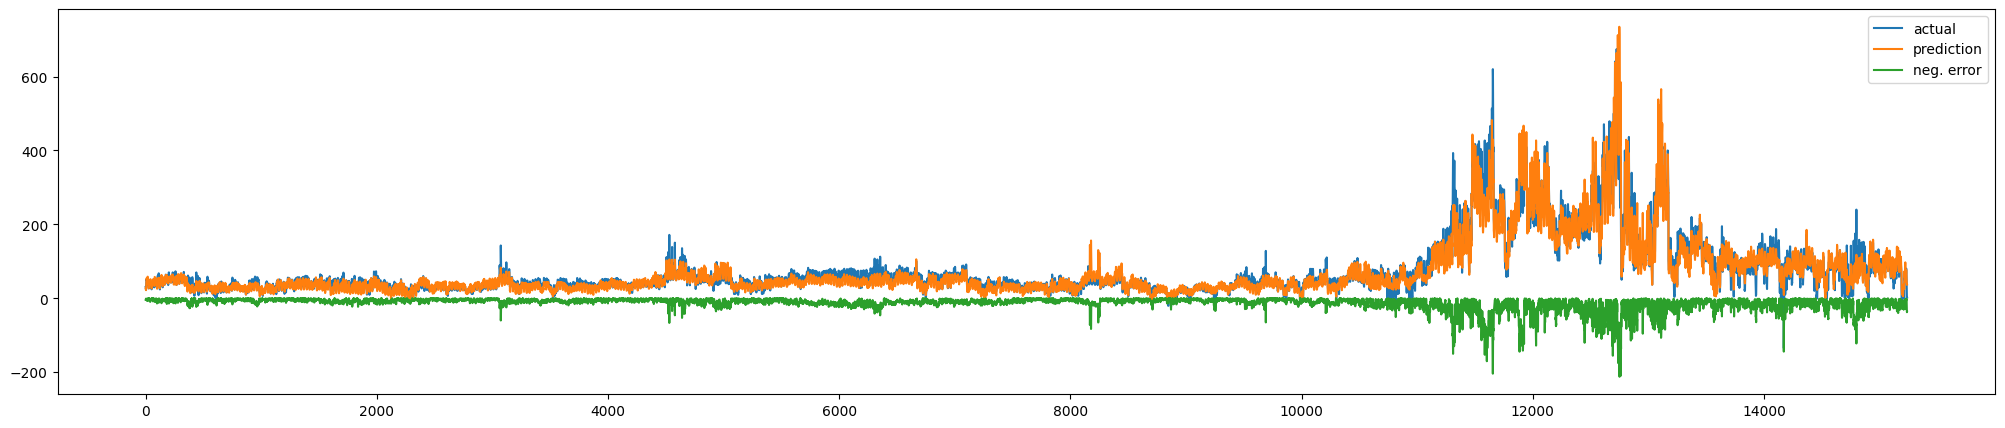

In [53]:
# plot prediction results (4-day intervals of test set are concatenated in order)
x_len = len(y_pred.sort_index().index)
plt.figure(figsize=(25, 5))
cutoff = x_len
plt.plot(range(x_len)[:cutoff], y_test_original.sort_index()[:cutoff], label='actual')
plt.plot(range(x_len)[:cutoff], y_pred.sort_index()[:cutoff], label='prediction')
error = -abs((y_pred.sort_index()['pl_pred']-y_test_original.sort_index()['price_da'])[:cutoff])
plt.plot(range(x_len)[:cutoff], error, label='neg. error')
plt.legend()